In [1]:
import pydicom
import numpy as np
from pathlib import Path
from tqdm import tqdm

In [20]:
# Parameters for Cube Geometry
cube_half_width = 75 # mm
cube_inside_bevel = 67 # mm
bevel_radius = cube_half_width - cube_inside_bevel
cube_HU = -15

sphere_diameter = 7.5 # mm
sphere_centers = np.array([[-10,-25,-30],[10,-15,-15],[0,0,0],[-20,20,10],[20,30,20]])
sphere_HU = 3060

# Parameters to jitter cube surface to make it imperfect
include_jitter = False
max_jitter = 0.02 # mm

# Parameters for Image Geometry
image_matrix_size = 256
image_physical_size = 200 # mm
image_pixel_size = image_physical_size / image_matrix_size
image_positions = np.arange(image_matrix_size)*image_pixel_size + image_pixel_size/2 - image_physical_size/2


# Parameters for Slice Geometry
number_of_slices = 1
image_physical_length = 200 # mm
slice_width = image_physical_length / number_of_slices # plus one?
slice_positions = np.arange(number_of_slices)*slice_width + slice_width/2 - image_physical_length/2

In [5]:
def is_in_sphere(loc):
    """Checks whether the point loc is in the cube
    
    PARAMETERS
    ----------
    loc : list of float
        A list of length 3 corresponding to the x, y and z coordinates of the point
    
    RETURNS
    -------
    True if the point is in the a sphere, else False
    
    """
    
    assert len(loc) == 3, "loc must be a list of three floating point integers"
    
    for origin in sphere_centers:
        vec = loc - origin
        dist = np.linalg.norm(vec)
        if dist <= sphere_diameter/2:
            return True
    
    return False

def is_in_cube(loc, rounded_edges=True):
    """Checks whether the point loc is in the cube
    
    PARAMETERS
    ----------
    loc : list of float
        A list of length 3 corresponding to the x, y and z coordinates of the point
    rounded_edges: bool
        If True, evaluates for a cube with rounded edges. If false, assumes cube
        has sharp edges (default is True)
    
    RETURNS
    -------
    True if the point is in the cube, else False
    
    """
    
    assert len(loc) == 3, "loc must be a list of three floating point integers"
    
    # Cube is symmetric, take abs of x,y,z, convert to ndarray which allows slicing
    loc = np.abs(loc)
    
    # Case 1: Any of the values are greater than the cube half-width, return false:
    if any(loc > cube_half_width):
        return False
    
    # If we are not using rounded edges, then we are done. Return True
    if not rounded_edges:
        return True
    
    # Case 2: All of the values are less than the cube_inside_bevel, return True:
    if all(loc <= cube_inside_bevel):
        return True
    
    # Case 3: If exactly one dimension is greater than cube_inside_bevel, 
    # then the point is adjacent to a cube face, return True:
    if sum(loc > cube_inside_bevel) == 1:
        return True

    # Case 4: If exactly two dimensions are greater than cube_inside_bevel, 
    # then the point is adjacent to a cube edge. The point defined by the two
    # dimensions that are greater than the cube_inside_bevel must be within a 
    # radius of bevel_radius of the point cube_inside_bevel*[1,1]:
    if sum(loc > cube_inside_bevel) == 2:
        
        # Get the indicies whose value is greater than cube_inside_bevel
        tf_array = loc > cube_inside_bevel
    
        # Create a 2D vector from the origin to the point in the edge region
        origin = cube_inside_bevel*np.ones((3,1))
        
        vec = loc[tf_array] - origin[tf_array]
        dist = np.linalg.norm(vec)
        if dist <= bevel_radius:
            return True
        else:
            return False
    
    # Case 5: If exactly three dimensions are greater than cube_inside_bevel, 
    # then the point is adjacent to a cube corner. The point must be within a 
    # radius of bevel_radius of the point cube_inside_bevel*[1,1,1]:
    if sum(loc > cube_inside_bevel) == 3:
        origin = cube_inside_bevel*np.ones((3,1))
        vec = loc - origin
        dist = np.linalg.norm(vec)
        if dist <= bevel_radius:
            return True
        else:
            return False
    
    



In [6]:
def is_in_sphere_np(x, y, z):
    """
    
    PARAMETERS
    ----------
    x : list of float
        A list of image coordinates in the x-dimension
    y : list of float
        A list of image coordinates in the y-dimension
    z : list of float
        A list of image coordinates in the z-dimension
    
    RETURNS
    -------
    A 3D array of shape (len(x),len(y),len(z)), where the array value (i,j,k) is True 
    if the point x[i], y[j], z[k] is locted in a in the a sphere, else False
    
    """
        
    XX, YY, ZZ = np.meshgrid(x, y, z, indexing='ij')
    
    is_in_sphere_array = np.zeros(XX.shape, dtype=bool)
    
    for origin in sphere_centers:
        DXX = XX - origin[0]
        DYY = YY - origin[1]
        DZZ = ZZ - origin[2]
        
        quad_sum = np.square(DXX) + np.square(DYY) + np.square(DZZ)
        
        is_in_this_sphere = (quad_sum <= (sphere_diameter/2)**2)
        
        np.logical_or(is_in_this_sphere, is_in_sphere_array, out=is_in_sphere_array)
    
    return is_in_sphere_array

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.07s/it]


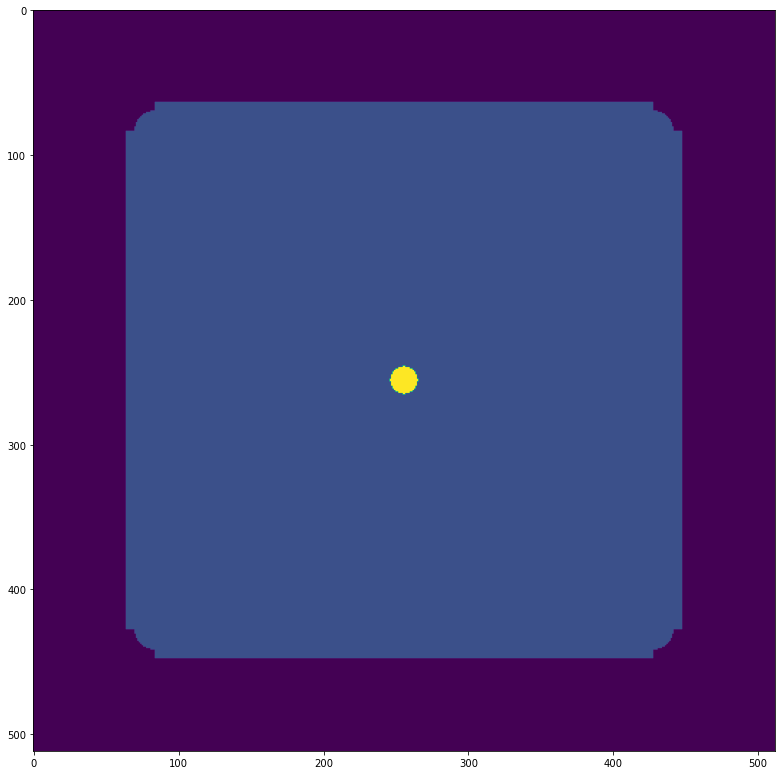

In [7]:
slice_collection = []
for k, z in enumerate(tqdm(slice_positions)):
    
    pixel_map = np.zeros((image_matrix_size, image_matrix_size))-1000
    for i, x in enumerate(image_positions):
        for j, y in enumerate(image_positions):
            
            if is_in_sphere((x, y, z)):
                pixel_map[i][j] = sphere_HU
            elif is_in_cube((x, y, z)):
                pixel_map[i][j] = cube_HU
                

    slice_collection.append(pixel_map)

slices = slice_collection

# pixel aspects, assuming all slices are the same
ps = (image_pixel_size,image_pixel_size)
ss = slice_width
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
f, axs = plt.subplots(1,1,figsize=(30,30))
axs = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])

plt.show()

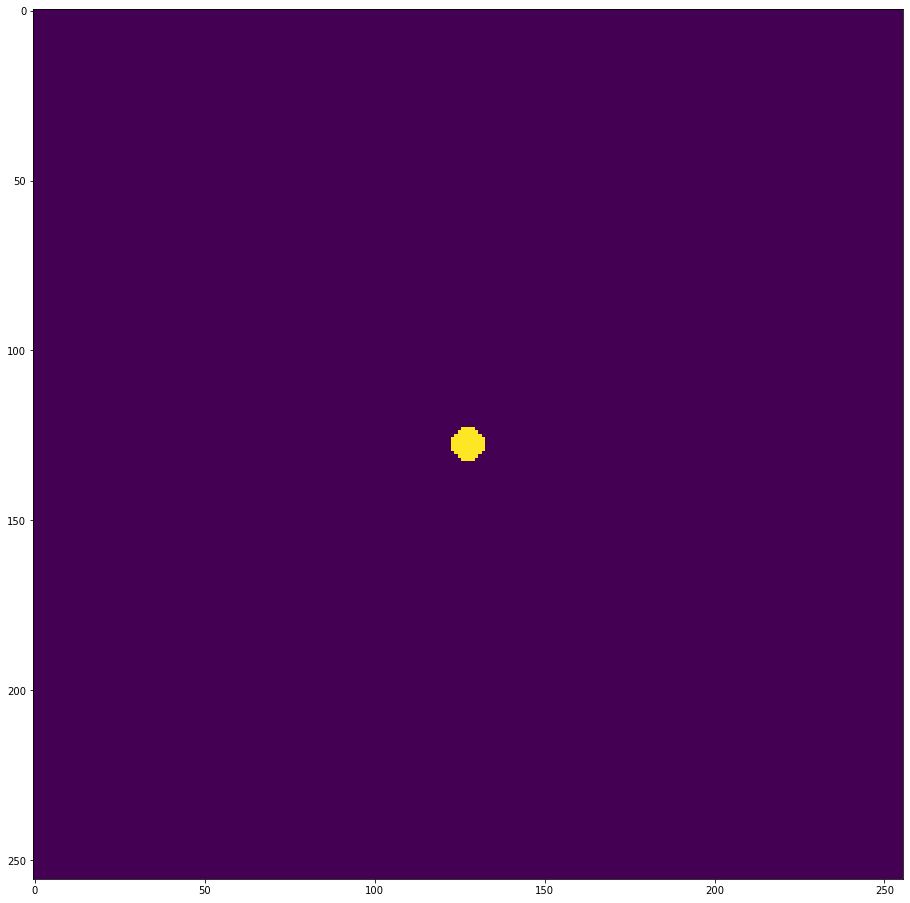

In [21]:
pixel_map = np.zeros((image_matrix_size, image_matrix_size, number_of_slices))-1000

tf_in_sphere = is_in_sphere_np(image_positions, image_positions, slice_positions)

pixel_map[tf_in_sphere] = sphere_HU

img_shape = list(pixel_map.shape)

img3d = pixel_map


# plot 3 orthogonal slices
f, axs = plt.subplots(1,1,figsize=(16,16))

plt.imshow(img3d[img_shape[0]//2,:,:])
plt.imshow(img3d[:, img_shape[1]//2, :])
plt.imshow(img3d[:, :, img_shape[2]//2])

plt.show()



In [22]:
image_positions

array([-99.609375, -98.828125, -98.046875, -97.265625, -96.484375,
       -95.703125, -94.921875, -94.140625, -93.359375, -92.578125,
       -91.796875, -91.015625, -90.234375, -89.453125, -88.671875,
       -87.890625, -87.109375, -86.328125, -85.546875, -84.765625,
       -83.984375, -83.203125, -82.421875, -81.640625, -80.859375,
       -80.078125, -79.296875, -78.515625, -77.734375, -76.953125,
       -76.171875, -75.390625, -74.609375, -73.828125, -73.046875,
       -72.265625, -71.484375, -70.703125, -69.921875, -69.140625,
       -68.359375, -67.578125, -66.796875, -66.015625, -65.234375,
       -64.453125, -63.671875, -62.890625, -62.109375, -61.328125,
       -60.546875, -59.765625, -58.984375, -58.203125, -57.421875,
       -56.640625, -55.859375, -55.078125, -54.296875, -53.515625,
       -52.734375, -51.953125, -51.171875, -50.390625, -49.609375,
       -48.828125, -48.046875, -47.265625, -46.484375, -45.703125,
       -44.921875, -44.140625, -43.359375, -42.578125, -41.796

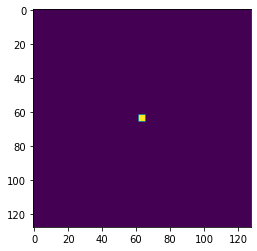

In [193]:
plt.imshow(is_in_sphere_array)

In [189]:
quad_sum.shape

(128, 128, 1)

In [226]:
7.5 / image_pixel_size

9.6

In [102]:
(sphere_diameter/2)**2

14.0625

file count: 258
skipped, no SliceLocation: 0


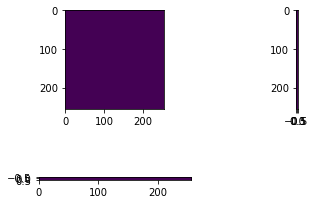

In [14]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

dicom_path = Path("../visionrt-cube-dicom/data/")

# load the DICOM files
files = []

for fname in dicom_path.iterdir():
    # print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
        break
        
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [15]:
thejeff = pydicom.dcmread(fname)

In [19]:
f

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.77547029415988507727916493120304174686
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20200709'
(0008, 0013) Instance Creation Time              TM: '112407'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Insta